# rough maximize

Given integer $k$ and array $b$ of length $2^k$.

Search as good solution as possible for the following optimization problem.
$$
    \max_{Q\in \mathbb{F}_2^{k\times k}, c \in \mathbb{F}_2^k} \sum_{x=0}^{2^k-1} (-1)^{x^\top Q x} i^{c^\top x} b_x
$$


36893488147419103232 patterns
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
fast: 4.939890840120467
19467 loops


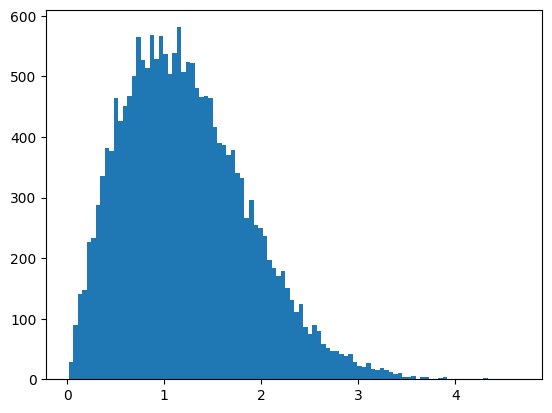

rand: 4.662498754291007


In [59]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import njit
from tqdm.auto import tqdm
from exputils.Amat.recover import make_state_from_kQctR


def slow(k: int, B: np.ndarray):
    values = []
    eye = np.array([1 << i for i in range(k)])
    for Q in tqdm(range(1 << (k * (k + 1) // 2))):
        for c in range(1 << k):
            indices, data = make_state_from_kQctR(k, k, Q, c, 0, eye)
            state = np.zeros(1 << k, dtype=complex)
            state[indices] = data
            values.append(np.abs(np.dot(state, B)))
    values = np.sort(values)
    plt.plot(values)
    plt.show()
    return max(values)


@njit(cache=True)
def calc(k: int, b: np.ndarray, Q: int, c: int):
    coeff = 1.0 / (2 ** (k / 2))
    ret = 0.0 + 0.0j
    for x in range(1 << k):
        cx = 0
        xQx = 0
        Q_idx = 0
        for i in range(k):
            cx ^= ((x >> i) & 1) * ((c >> i) & 1)
            for j in range(i, k):
                if (x & (1 << i)) and (x & (1 << j)) and (Q & (1 << Q_idx)):
                    xQx ^= 1
                Q_idx += 1
        ret += coeff * ((-1) ** xQx) * ((1j) ** cx) * b[x]
    return abs(ret)


def rand(k: int, B: np.ndarray):
    np.random.seed(0)
    random.seed(0)
    start_time = time.time()
    Q_MAX = 1 << (k * (k + 1) // 2)
    c_MAX = 1 << k
    values = []
    loop_cnt = 0
    while time.time() - start_time < 10:
        loop_cnt += 1
        Q = random.randrange(Q_MAX)
        c = random.randrange(c_MAX)
        val = calc(k, B, Q, c)
        values.append(val)
        # print(val)
    print(f"{loop_cnt} loops")
    plt.hist(values, bins=100)
    plt.show()
    return max(values)


def randRangePow2(m):
    ret = 0
    for i in range(m):
        ret |= random.randint(0, 1) << i
    return ret


def fast(k: int, B: np.ndarray):
    np.random.seed(0)
    random.seed(0)
    Q_non_diag = []
    Q_idx = 0
    for i in range(k):
        for j in range(i, k):
            if i != j:
                xs = []
                for x in range(1 << k):
                    if ((x >> i) & 1) & ((x >> j) & 1):
                        xs.append(x)
                Q_non_diag.append((Q_idx, xs))
            Q_idx += 1
    coeff = 1.0 / (2 ** (k / 2))
    max_val = 0
    start_time = time.time()
    coeffs = [0 + 0j for _ in range(1 << k)]
    Ps = list(range(len(Q_non_diag)))
    while time.time() - start_time < 10:
        Q = randRangePow2(k * (k + 1) // 2)
        c = randRangePow2(k)
        for x in range(1 << k):
            cx = 0
            xQx = 0
            Q_idx = 0
            for i in range(k):
                cx ^= ((x >> i) & 1) & ((c >> i) & 1)
                for j in range(i, k):
                    if ((Q >> Q_idx) & 1) & ((x >> i) & 1) & ((x >> j) & 1):
                        xQx ^= 1
                    Q_idx += 1
            coeffs[x] = coeff * ((-1) ** xQx) * ((1j) ** cx)
        sum_B2 = np.dot(coeffs, B)
        now_abs = abs(sum_B2)
        while True:
            random.shuffle(Ps)
            for p in Ps:
                Q_idx, xs = Q_non_diag[p]
                cur_sum = sum_B2
                for x in xs:
                    cur_sum -= 2 * B[x] * coeffs[x]
                if abs(cur_sum) > now_abs:
                    sum_B2 = cur_sum
                    now_abs = abs(cur_sum)
                    Q ^= 1 << Q_idx
                    for x in xs:
                        coeffs[x] *= -1
                    break
            else:
                break
        assert np.isclose(now_abs, calc(k, B, Q, c))
        max_val = max(max_val, now_abs)
    return max_val


def main():
    k = 10
    B = np.random.normal(0, 1, (2**k)) + 1j * np.random.normal(0, 1, (2**k))

    print(f"{1<<(k+k*(k+1)//2)} patterns")

    if k <= 4:
        s = slow(k, B)
        print(f"slow: {s}")
    f = fast(k, B)
    print(f"fast: {f}")
    r = rand(k, B)
    print(f"rand: {r}")


if __name__ == "__main__":
    main()

In [ ]:
@njit(cache=True)
def calc(k: int, b: np.ndarray, Q: int, c: int):
    coeff = 1.0 / (2 ** (k / 2))
    ret = 0.0 + 0.0j
    for x in range(1 << k):
        cx = 0
        xQx = 0
        Q_idx = 0
        for i in range(k):
            cx ^= ((x >> i) & 1) * ((c >> i) & 1)
            for j in range(i, k):
                if (x & (1 << i)) and (x & (1 << j)) and (Q & (1 << Q_idx)):
                    xQx ^= 1
                Q_idx += 1
        ret += coeff * ((-1) ** xQx) * ((1j) ** cx) * b[x]
    return abs(ret)


def randRangePow2(m):
    ret = 0
    for i in range(m):
        ret |= random.randint(0, 1) << i
    return ret


def fast(k: int, B: np.ndarray):
    np.random.seed(0)
    random.seed(0)
    Q_non_diag = []
    Q_idx = 0
    for i in range(k):
        for j in range(i, k):
            if i != j:
                xs = []
                for x in range(1 << k):
                    if ((x >> i) & 1) & ((x >> j) & 1):
                        xs.append(x)
                Q_non_diag.append((Q_idx, xs))
            Q_idx += 1
    coeff = 1.0 / (2 ** (k / 2))
    max_val = 0
    start_time = time.time()
    coeffs = [0 + 0j for _ in range(1 << k)]
    Ps = list(range(len(Q_non_diag)))
    while time.time() - start_time < 10:
        Q = randRangePow2(k * (k + 1) // 2)
        c = randRangePow2(k)
        for x in range(1 << k):
            cx = 0
            xQx = 0
            Q_idx = 0
            for i in range(k):
                cx ^= ((x >> i) & 1) & ((c >> i) & 1)
                for j in range(i, k):
                    if ((Q >> Q_idx) & 1) & ((x >> i) & 1) & ((x >> j) & 1):
                        xQx ^= 1
                    Q_idx += 1
            coeffs[x] = coeff * ((-1) ** xQx) * ((1j) ** cx)
        sum_B2 = np.dot(coeffs, B)
        now_abs = abs(sum_B2)
        while True:
            random.shuffle(Ps)
            for p in Ps:
                Q_idx, xs = Q_non_diag[p]
                cur_sum = sum_B2
                for x in xs:
                    cur_sum -= 2 * B[x] * coeffs[x]
                if abs(cur_sum) > now_abs:
                    sum_B2 = cur_sum
                    now_abs = abs(cur_sum)
                    Q ^= 1 << Q_idx
                    for x in xs:
                        coeffs[x] *= -1
                    break
            else:
                break
        assert np.isclose(now_abs, calc(k, B, Q, c))
        max_val = max(max_val, now_abs)
    return max_val